In [ ]:
# TODO:
# try roll-forward partitioning

# Creating synthetic dataset

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras

In [19]:
def plot_series(time, series, format="-", start=0, end=None, name=None):
    plt.plot(time[start:end], series[start:end], format, label=name)
    plt.xlabel("Time")
    plt.ylabel("Value")
    plt.grid(True)
    if name:
        plt.legend()

def trend(time, slope=0):
    return slope * time

def seasonal_pattern(season_time):
    """Just an arbitrary pattern, you can change it if you wish"""
    return np.where(season_time < 0.4,
                    np.cos(season_time * 2 * np.pi),
                    1 / np.exp(3 * season_time))

def seasonality(time, period, amplitude=1, phase=0):
    """Repeats the same pattern at each period"""
    season_time = ((time + phase) % period) / period
    return amplitude * seasonal_pattern(season_time)

def noise(time, noise_level=1, seed=None):
    rnd = np.random.RandomState(seed)
    return rnd.randn(len(time)) * noise_level

In [4]:
baseline = 10
slope = 0.01
amplitude = 40
noise_level = 5
time = np.arange(4 * 365 + 1, dtype="float32")
series1 = trend(time, slope)  
slope = 0.05
series2 = trend(time, slope) 
series3 = baseline + series2 + seasonality(time, period=365, amplitude=amplitude)
series3 += noise(time, noise_level, seed=42)

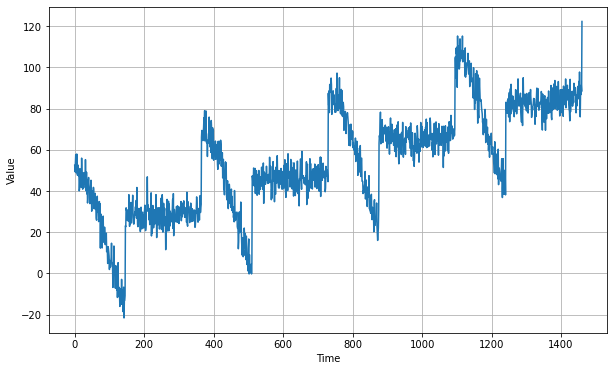

In [5]:
plt.figure(figsize=(10, 6))
plot_series(time, series3)
plt.show()

Text(0.5, 1.0, 'validation')

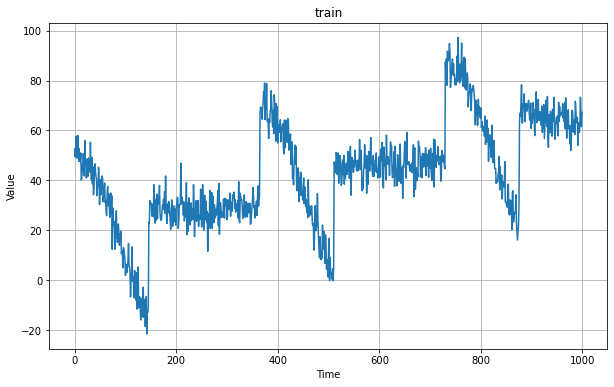

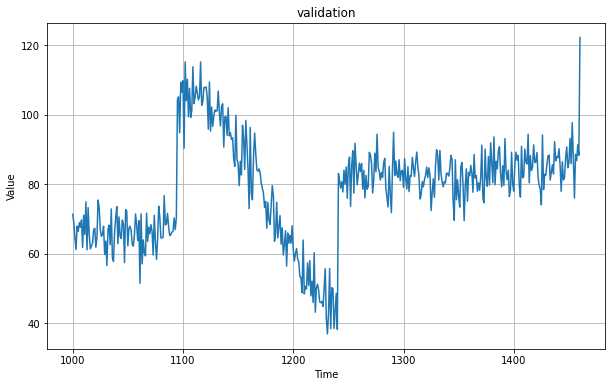

In [9]:
split_time = 1000 # 2 yrs
time_train = time[:split_time]
x_train = series3[:split_time]
time_valid = time[split_time:]
x_valid = series3[split_time:]

plt.figure(figsize=(10, 6))
plot_series(time_train, x_train)
plt.title("train")

plt.figure(figsize=(10, 6))
plot_series(time_valid, x_valid)
plt.title("validation")

# Statistical methods

## naive 

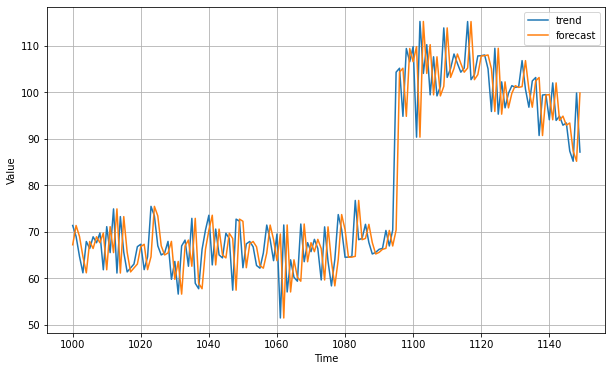

In [15]:
naive_forecast = series3[split_time - 1:-1]

plt.figure(figsize=(10, 6))
plot_series(time_valid, x_valid, start=0, end=150, name="trend")
plot_series(time_valid, naive_forecast, start=0, end=150, name="forecast")

In [16]:
print(keras.metrics.mean_squared_error(x_valid, naive_forecast).numpy())
print(keras.metrics.mean_absolute_error(x_valid, naive_forecast).numpy())

61.827538
5.9379086


## moving average

In [17]:
def moving_average_forecast(series, window_size):
    """Forecasts the mean of the last few values.
    If window_size=1, then this is equivalent to naive forecast"""
    forecast = []
    for time in range(len(series) - window_size):
        forecast.append(series[time:time + window_size].mean())
    return np.array(forecast)

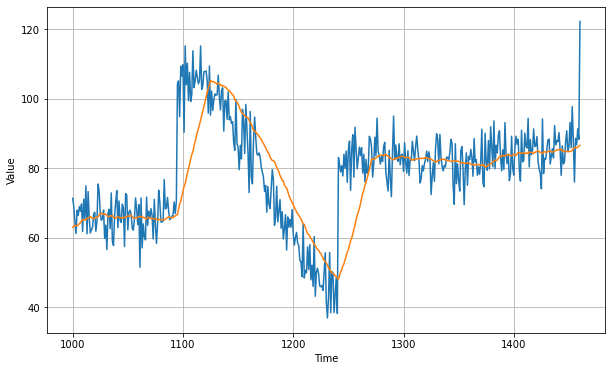

In [20]:
moving_avg = moving_average_forecast(series3, 30)[split_time - 30:]

plt.figure(figsize=(10, 6))
plot_series(time_valid, x_valid)
plot_series(time_valid, moving_avg)

In [21]:
print(keras.metrics.mean_squared_error(x_valid, moving_avg).numpy())
print(keras.metrics.mean_absolute_error(x_valid, moving_avg).numpy())

106.674576
7.142419


## differencing

In [29]:
len(series3)//365

4

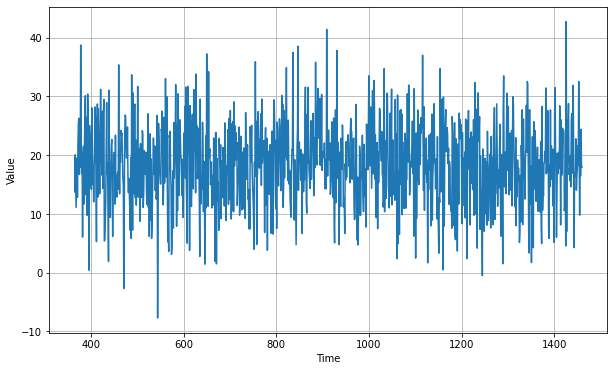

In [23]:
diff_series = (series3[365:] - series3[:-365]) # YoY difference 
diff_time = time[365:]

plt.figure(figsize=(10, 6))
plot_series(diff_time, diff_series)


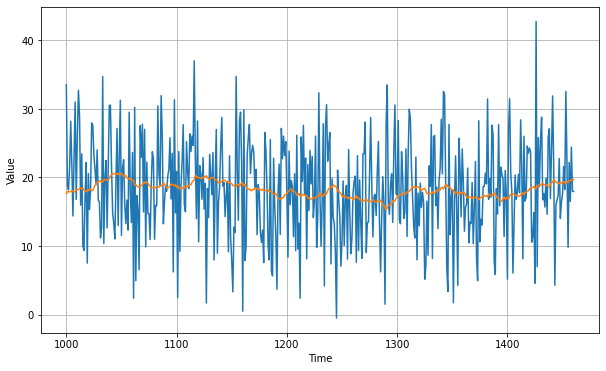

In [32]:
window = 50 #days
diff_moving_avg = moving_average_forecast(diff_series, window)[split_time - 365 - window:] # [635 - window :]

plt.figure(figsize=(10, 6))
plot_series(time_valid, diff_series[split_time - 365:])
plot_series(time_valid, diff_moving_avg)


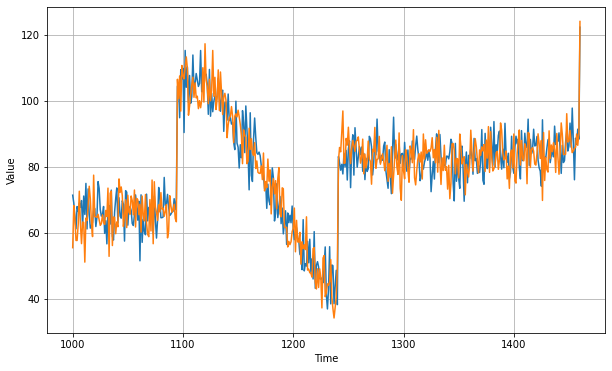

In [25]:
diff_moving_avg_plus_past = series3[split_time - 365:-365] + diff_moving_avg

plt.figure(figsize=(10, 6))
plot_series(time_valid, x_valid)
plot_series(time_valid, diff_moving_avg_plus_past)

In [26]:
print(keras.metrics.mean_squared_error(x_valid, diff_moving_avg_plus_past).numpy())
print(keras.metrics.mean_absolute_error(x_valid, diff_moving_avg_plus_past).numpy())

52.973656
5.8393106


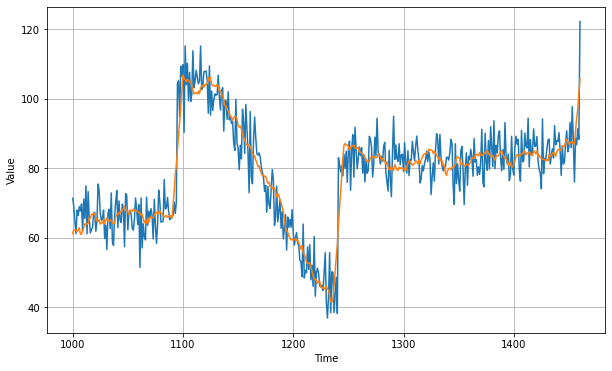

In [30]:
window = 10 
diff_moving_avg_plus_smooth_past = moving_average_forecast(series3[split_time - 370:-360], window) + diff_moving_avg

plt.figure(figsize=(10, 6))
plot_series(time_valid, x_valid)
plot_series(time_valid, diff_moving_avg_plus_smooth_past)
plt.show()

In [36]:
print(keras.metrics.mean_squared_error(x_valid, diff_moving_avg_plus_smooth_past).numpy())
print(keras.metrics.mean_absolute_error(x_valid, diff_moving_avg_plus_smooth_past).numpy())

33.45226
4.569442
